### Solving a diffusion equation for different conductivty fields
We want to solve the following equation
\begin{align*}
    -\text{div}(\kappa(x) \nabla u(x)) &= 10 &&\text{ in } \Omega, \\
    u &= 0 &&\text{ on } \partial \Omega,
\end{align*}
for functions $\kappa: \Omega \to \mathbb{R}$. As a domain we consider the unit square $\Omega = [0, 1]^2$.

The possible $\kappa$ are generated from [perlin noise](https://en.wikipedia.org/wiki/Perlin_noise) and the dataset was generated using the finite element method. 

This example shows the workflow in TorchPhysics for such a 2D problem. We will not get highly accurate results because we are working with a small dataset of 600 instances of pairs $(\kappa, u)$. This is done to keep the size of the GitHub repository small.
Better results can be obtained with more data.

In [1]:
import os, sys
sys.path.append(os.getcwd())

import torch 
import torchphysics as tp
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

First, we load the data. 
The complete dataset consists of 600 instances of pairs $(\kappa, u)$. 
500 will be used in the training process, while the remaining once are later used to test the FNO on unseen data.

As mentioned before, this is quite a small data set and we can not expect to obtain a good generalization of the model. 


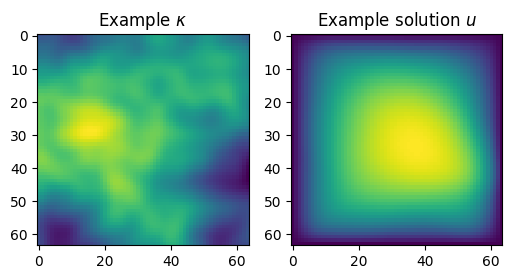

In [2]:
input_data = torch.tensor(np.load("datasets/diffusion_input_small.npy"), dtype=torch.float32)
output_data = torch.tensor(np.load("datasets/diffusion_output_small.npy"), dtype=torch.float32)

train_batch_size = 500
train_input = input_data[:train_batch_size]
train_output = output_data[:train_batch_size]

# Plot one example of the data
f, axarr = plt.subplots(1,2, figsize=(6, 10))
plot_idx = 142
axarr[0].imshow(train_input[plot_idx])
axarr[0].title.set_text(r"Example $\kappa$")
axarr[1].imshow(train_output[plot_idx])
axarr[1].title.set_text(r"Example solution $u$")

In TorchPhysics we have to define the input and output space like always:

In [3]:
X = tp.spaces.R2("x")
K = tp.spaces.R1("k")
U = tp.spaces.R1("u")

function_space_input = tp.spaces.FunctionSpace(X, K)
function_space_output = tp.spaces.FunctionSpace(X, U)

In [4]:
# Put the data into the FunctionSet format
data_functionset_input = tp.domains.DataFunctionSet(function_space_input, input_data)
data_functionset_output = tp.domains.DataFunctionSet(function_space_output, output_data)

functionsampler_input = tp.samplers.FunctionSamplerOrdered(250, data_functionset_input)
# The output should be coupled to the correct input functions:
functionsampler_output = tp.samplers.FunctionSamplerCoupled(data_functionset_output, functionsampler_input)

Next we create the network that learns the mapping. Again we can easily switch between different approaches:

In [5]:
### DeepONet
x_grid = torch.linspace(0, 1, 64)
point_grid = torch.permute(torch.stack(torch.meshgrid((x_grid, x_grid))), (2, 1, 0)).unsqueeze(0)
trunk_net = tp.models.FCTrunkNet(X, hidden=(10, 10), default_trunk_input=point_grid)

conv_network = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    torch.nn.Tanh(),
    torch.nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    torch.nn.Tanh(),
    torch.nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
    torch.nn.Tanh()
)

branch_net = tp.models.ConvBranchNet(function_space_input, 
                                     convolutional_network=conv_network,
                                     hidden=(20, 20), grid=point_grid)


model = tp.models.DeepONet(trunk_net, branch_net, U, output_neurons=50)

/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
### FNO:
# hidden_channels = 12

# model = tp.models.FNO(K, U, 
#                       fourier_layers=4, 
#                       hidden_channels=hidden_channels, 
#                       fourier_modes=(12, 12), # Here two modes need to be set (one for each space direction) 
#                       skip_connections=True, 
#                       channel_down_sample_network=torch.nn.Sequential(
#                           torch.nn.Linear(hidden_channels, hidden_channels),
#                           torch.nn.Tanh(),
#                           torch.nn.Linear(hidden_channels, U.dim)
#                       ))

In [7]:
### Model order reduction network:
# data_functionset_input.compute_pca(components=50)
# data_functionset_output.compute_pca(components=50)

# model = tp.models.PCANN_FC.from_fn_set(
#     data_functionset_input, data_functionset_output, hidden=(60, 80, 100, 80, 60)
# )

Now we create a data condition to fit the model to the data:

In [8]:
data_condition = tp.conditions.OperatorCondition(module=model, 
                                        input_function_sampler=functionsampler_input, 
                                        output_function_sampler=functionsampler_output)

Start training:

In [9]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.005)
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=10000, 
                     logger=False, 
                     enable_checkpointing=False)

trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 4.8 K 
1 | val_conditions   | ModuleList | 0     
----------

Epoch 0: 100%|██████████| 10000/10000 [01:09<00:00, 144.05it/s, train/loss=0.501]

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 0: 100%|██████████| 10000/10000 [01:09<00:00, 144.04it/s, train/loss=0.501]


In [10]:
functionsampler_input.n_functions = 500

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=5000, 
                     logger=False, 
                     enable_checkpointing=False)

trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 9.9 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
9.9 K     Trainable params
0         Non-trainable params
9.9 K     Total params
0.040     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 5000/5000 [00:33<00:00, 147.15it/s, train/loss=0.405]

`Trainer.fit` stopped: `max_steps=5000` reached.


Epoch 0: 100%|██████████| 5000/5000 [00:33<00:00, 147.14it/s, train/loss=0.405]


Check the results on unseen data (as explained before the results will be not great but should roughly predict the solution)

In [11]:
test_input = input_data[train_batch_size:]
test_output = output_data[train_batch_size:]

if isinstance(model, tp.models.DeepONet):
    model_output = model(branch_inputs=tp.spaces.Points(test_input, K)).as_tensor
else:
    model_output = model(tp.spaces.Points(test_input, K)).as_tensor

rel_error = torch.max(torch.abs(model_output - test_output)) / torch.max(test_output)

print(f"Relative error: {rel_error*100} %")

Relative error: 44.55781936645508 %


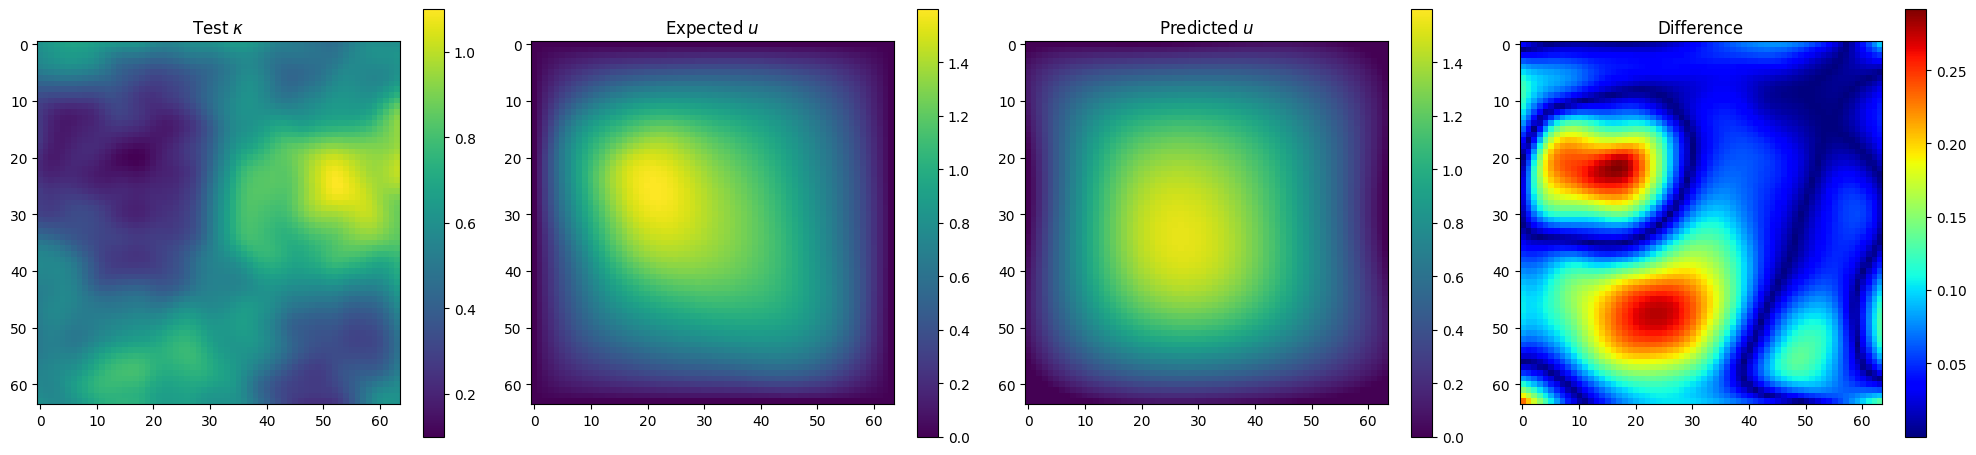

In [12]:
# Plot one example of data
plot_idx = 1 # <- value between 0 and 99

f, axarr = plt.subplots(1,4, figsize=(20, 6))
img = axarr[0].imshow(test_input[plot_idx])
axarr[0].title.set_text(r"Test $\kappa$")
plt.colorbar(img, ax=axarr[0], shrink=0.75)

sol_min = torch.min(test_output[plot_idx])
sol_max = torch.max(test_output[plot_idx])
img = axarr[1].imshow(test_output[plot_idx], vmin=sol_min, vmax=sol_max)
axarr[1].title.set_text(r"Expected $u$")
plt.colorbar(img, ax=axarr[1], shrink=0.75)

img = axarr[2].imshow(model_output[plot_idx].detach(), vmin=sol_min, vmax=sol_max)
axarr[2].title.set_text(r"Predicted $u$")
plt.colorbar(img, ax=axarr[2], shrink=0.75)

error = torch.abs(model_output[plot_idx].detach() - test_output[plot_idx])
img = axarr[3].imshow(error, cmap='jet')
axarr[3].title.set_text(r"Difference")
plt.colorbar(img, ax=axarr[3], shrink=0.75)

plt.tight_layout()